<div style="font-family: Arial, Helvetica, sans-serif;">
    <div style="display: flex;padding-top: 20px">
        <div><strong>Môn học:</strong> Trực quan hóa dữ liệu</div>
    </div>
    <div style="display: flex;padding-top: 20px">
        <div style="padding-right: 10px;"><strong>Lớp:</strong> 22KHDL</div>
        <div></div>
    </div>
    <div>
        <div style="display: flex;padding-top: 20px">
            <div style="padding-right: 10px;"><strong>Thành viên:</strong></div>
            <div></div>
        </div>
        <table style="font-size: 15px; display:flex;padding-top: 20px">
            <tr>
                <th>No.</th>
                <th>Student ID</th>
                <th>Name</th>
            </tr>
            <tr>
                <td>1</td>
                <td>22127008</td>
                <td style="text-align:left;">Đặng Châu Anh</td>
            </tr>
            <tr>
                <td>2</td>
                <td>22127014</td>
                <td style="text-align:left;">Nguyễn Kim Anh</td>
            </tr>
            <tr>
                <td>4</td>
                <td>22127170</td>
                <td style="text-align:left;">Trần Dịu Huyền</td>
            </tr>
        </table>
    </div>
    <div style="font-size: 25px ;font-weight: 800; text-align: center;padding-top: 20px;">LAB 01</div>
    <div style="font-size: 20px ;font-weight: 800; text-align: center;padding-top: 20px;">THU THẬP DỮ LIỆU VÀ TRỰC QUAN HÓA DỮ LIỆU</div>
</div>

# **Mục lục**

- [**Giới thiệu**](#intro)
    - [Mục tiêu đồ án](#objectives)
    - [Thông tin dữ liệu](#data)
- [**Thư viện sử dụng**](#packages)
- [**Thu thập dữ liệu**](#collect)
- [**Khám phá dữ liệu**](#eda)
    - [**Tổng quan về dữ liệu**](#eda1)
    - [**EDA và tiền xử lí dữ liệu**](#eda2)
        - [**Thống kê mô tả**](#eda21)
        - [**Phân bố của dữ liệu dạng số**](#eda22)
        - [**Phân bố của dữ liệu dạng phân loại**](#eda23)
    - [**EDA và tiền xử lí dữ liệu**](#eda3)
- [**Trực quan hóa dữ liệu**](#visual)


<a id="intro"></a>
# **I. Giới thiệu**
<a id="objectives"></a>
## **1. Mục tiêu phân tích:**
- Thị hiếu âm nhạc của người nghe ở thị trường Việt Nam
<a id="data"></a>
## **2. Thông tin dữ liệu:**


<a id="packages"></a>
# **II. Thư viện sử dụng**

In [2]:
from dotenv import load_dotenv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import glob

<a id="collect"></a>
# **III. Thu thập dữ liệu**

Sau khi khảo sát và tìm hiểu về trình nghe nhạc trực tuyến **Spotify**, mục tiêu ban đầu mà nhóm xác định được cho việc thu thập dữ liệu là sẽ lấy tất cả các thông tin về bảng xếp hạng tại **Spotify chart** và bài hát mà có thể lấy được từ trang web **Spotify**, bao gồm:
- URI
- Tên bài hát `track_name`
- Tên ca sĩ `artist_name`
- Thể loại `genre`
- Hãng đĩa/ Nhà phát hành `source`
- Thời lượng `duration`
- Số lượt nghe `streams`

Với mục tiêu này, việc thu thập dữ liệu sẽ được thực hiện với sự hỗ trợ của thư viện `BeautifulSoup`, `requests` và `Selenium` vì đây là một trang web động cần yêu cầu đăng nhập. Biến `BASE_URL` sẽ được sử dụng để lưu trữ URL của route đầu tiên của **Spotify chart** cần sử dụng để thu thập dữ liệu.

Đầu tiên chúng ta sẽ cài đặt ChromeDriver để sử dụng `Selenium`.

In [3]:
def initialize_chrome_driver():
   """
   Initialize Chrome WebDriver with specific configurations
   
   Args:
       user_name (str): Windows username for Chrome profile path
       
   Returns:
       webdriver.Chrome: Configured Chrome WebDriver instance
   """
   # Configure Chrome options
   chrome_options = Options()
   chrome_options.add_argument("--no-sandbox")
   chrome_options.add_argument("--start-maximized")
   
   # Configure download preferences
   chrome_options.add_experimental_option("prefs", {
       "download.default_directory": os.getcwd() + '.\\data',
       "download.prompt_for_download": False,
       "profile.default_content_setting_values.automatic_downloads": 1,
       "profile.default_content_setting_values.popups": 0,
   })
   
   # Initialize and return WebDriver
   return webdriver.Chrome(
       # Your path that contains chromedriver
       service=Service("C:/Program Files/chromedriver/chromedriver.exe"), 
       options=chrome_options
   )

Đây sẽ là phần xử lí login vào trang web Spotify chart, tên đăng nhập và mật khẩu sẽ được lưu trong file env để bảo mật thông tin.

In [21]:
def login (browser):    
    load_dotenv('.env.test')
    USER_NAME = os.getenv('USER_NAME')
    PASS_WORD = os.getenv('PASS_WORD')   
    
    login_button = WebDriverWait(browser, 10).until(
           EC.element_to_be_clickable((By.CSS_SELECTOR, "[data-testid='charts-login']"))
    )
    login_button.click()
    
    user_name = WebDriverWait(browser, 10).until(
           EC.element_to_be_clickable((By.CSS_SELECTOR, "[id='login-username']"))
    )
    user_name.click()
    user_name.send_keys(USER_NAME)
    
    pass_word = WebDriverWait(browser, 10).until(
           EC.element_to_be_clickable((By.CSS_SELECTOR, "[id='login-password']"))
    )
    pass_word.click()
    pass_word.send_keys(PASS_WORD)
    
    login = WebDriverWait(browser, 10).until(
           EC.element_to_be_clickable((By.CSS_SELECTOR, "[id='login-button']"))
    )
    login.click()
    
    WebDriverWait(browser, 10).until(EC.url_contains("https://charts.spotify.com/charts/overview/global"))

Tiếp theo chúng ta sẽ xử lí phần cookies vì nó sẽ che mất nút download

In [9]:
def handle_cookies_button(browser):
    exit_button = WebDriverWait(browser, 10).until(
           EC.element_to_be_clickable((By.CSS_SELECTOR, "[id='onetrust-close-btn-container']"))
    )
    
    exit_button.click()

Mục tiêu là thu thập dữ liệu top 200 mỗi tháng từ đầu năm 2018 đến nay, nhưng biến động giữa 1 tuần về việc ra nhạc là không nhiều nên nhóm quyết định lấy ngày đầu, ngày 15 và ngày cuối trong một tháng để thu thập dữ liệu, thời gian bắt đầu từ đầu năm 2018 đến cuối tháng 1 năm 2025.

Và cuối cùng chúng ta sẽ dùng Selenium để thu thập dữ liệu tự động từ trang web Spotify chart và dữ liệu sẽ được lưu tại địa chỉ `../data`

In [ ]:
def download_spotify_charts(start_month=1, start_year=2018, end_month=1, end_year=2025):
    """
    Download Spotify charts data for specified months
    
    Args:
        start_month (int): Starting month (default: 1)
        start_year (int): Starting year (default: 2024)
        end_month (int): Ending month (default: 1)
        end_year (int): Ending year (default: 2025)
    """
    # Dictionary of days in each month
    months = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    # Initialize Chrome
    browser = initialize_chrome_driver()
    browser.get("https://charts.spotify.com/home")
    login(browser)
    
    handle_cookies_button(browser)
    
    # Initialize tracking variables
    current_month, current_year = start_month, start_year
    
    # Process charts from start month/year to end month/year
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        days_to_scrape = [1, 15, months[current_month]]
        
        for day in days_to_scrape:
            url = f"https://charts.spotify.com/charts/view/regional-vn-daily/{current_year}-{current_month:02d}-{day:02d}"
            browser.get(url)
            
            try:
                download_button = WebDriverWait(browser, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-encore-id="buttonTertiary"]'))
                )
                download_button.click()
            except Exception as e:
                print(f"Failed to download data for {current_year}-{current_month:02d}-{day:02d}: {e}")
        
        # Update month and year tracking
        if current_month == 12:
            current_month = 1
            current_year += 1
        else:
            current_month += 1
    
    time.sleep(2)
    browser.quit()

download_spotify_charts()

Vậy là mỗi file csv đều có format tên là `regional-vn-weekly-2024-xx-xx.csv` với xx là ngày đầu, ngày 15 và ngày cuối của mỗi tháng. Tất cả các file này sẽ được lưu tại thư mục `../data` và tất cả sẽ được hợp lại thành file tên `spotify_chart.csv` và thêm cột `date` để biết được ngày thu thập dữ liệu.

In [47]:
path = '../data'
all_files = glob.glob(f"{path}/*.csv")

df_list = []

# Lấy ngày trong filename
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Hợp các dataframe lại
raw_df = pd.concat(df_list, ignore_index=True)

# Lưu dữ liệu vào file csv
raw_df.to_csv('../new_data/spotify_chart.csv', index=False)

raw_df

rank                                   uri  \
0         1  spotify:track:6XJsQ5nqCu8RUv9pv1iz1x   
1         2  spotify:track:0ZP4bO2ywAv44HiEzzHaq5   
2         3  spotify:track:08bNPGLD8AhKpnnERrAc6G   
3         4  spotify:track:2ARqIya5NAuvFVHSN3bL0m   
4         6  spotify:track:5yFSF6qQA1rcLsQRnBsZgb   
...     ...                                   ...   
33937   196  spotify:track:0gzpqwLf1jhNjnSJEyweAX   
33938   197  spotify:track:0Lf0ydJp4nbcEkYgPtIUuD   
33939   198  spotify:track:5Ad2WBPQGCa9bPskbob5dN   
33940   199  spotify:track:37uug3gaq86yvFTjV6WkaV   
33941   200  spotify:track:3xRwKsEaxuxKtS3n9ZrWJ1   

                                            artist_names  \
0                                                 Mỹ Tâm   
1                              Lê Hiếu, SOOBIN, Touliver   
2                                 Marshmello, Anne-Marie   
3                               Zedd, Maren Morris, Grey   
4      Alan Walker, Noah Cyrus, Digital Farm Animals,...   
...                                                  ...   
33937                            Kuun Đức Nam, Linh Thộn   
33938                                           Ronboogz   
33939                                      VCC Left Hand   
33940                                       Kay Chau Anh   
33941                                       Bùi Công Nam   

                             track_name               source  peak_rank  \
0                  Người Hãy Quên Em Đi     MT Entertainment          1   
1                        Ngày Mai Em Đi       Space Speakers          2   
2                               FRIENDS  Atlantic Records UK          3   
3                            The Middle     UMGRI Interscope          3   
4      All Falls Down (feat. Juliander)       Kreatell Music          6   
...                                 ...                  ...        ...   
33937                    Tình cờ yêu em         MaiDao Music          9   
33938                            Khi Mà         MaiDao Music        122   
33939     Mình Lượn Lờ Làm Wen (NOVINA)        VCC Left Hand        198   
33940                     Think About U       Yin Yang Media         89   
33941                 Tết Này Con Sẽ Về    BCN Entertainment         25   

       previous_rank  days_on_chart  streams  
0                  1              2    22216  
1                  2              2    12878  
2                  4              2     9858  
3                  3              2     9260  
4                  7              2     8471  
...              ...            ...      ...  
33937            167            523    17345  
33938            180            170    17311  
33939             -1              1    17229  
33940            195             78    17215  
33941            121             50    17183  

[33942 rows x 9 columns]

Vậy là chúng ta đã thu thập xong được dữ liệu từ trang web Spotify chart, tiếp theo chúng ta sẽ tiếp thục thu thập các trường còn thiếu và các trường còn thiếu này sẽ được lấy từ Spotify. Việc liên kết giữa những bài hát này và chúng trên Spotify sẽ thông qua `uri` của bài hát, vì biết rằng mỗi bài hát chỉ có một URI duy nhất. Và trang web Spotify chart cũng được cung cấp thông tin từ API của Spotify.

Đầu tiên, chúng ta sẽ lấy trích lấy URI của mỗi bài hát từ `raw_df` và lưu vào biến `track_id`.

In [159]:
def extract_id(uri):
    return uri.split(':')[-1]

track_id = []
for uri in raw_df['uri']:
    track_id.append(extract_id(uri))

Tiếp theo, chúng ta sẽ sử dụng `track_id` này để lấy được thông tin bài hát từ Spotify, cụ thể là `duration` - thời lượng, `release_date` - ngày phát hành của bài hát và `streams` - tổng số lượt nghe đến thời điểm hiện tại. Nhưng trước đó chúng ta phải gom nhóm các `track_id` trùng nhau và lấy ra một `track_id` duy nhất. Đồng thời chúng ta cũng sẽ sử dụng cột `id` mới thay cho `uri` cũ với dữ liệu vừa mới được định dạng này.

In [ ]:
unique_tracks = raw_df.drop_duplicates(subset=['uri'])
track_id = unique_tracks['uri'].tolist()
track_id = [extract_id(uri) for uri in track_id]
raw_df['id'] = raw_df['uri'].apply(extract_id)
raw_df.drop(columns=['uri'], inplace=True)

Đây là hàm lấy dữ liệu của mỗi bài hát từ Spotify, chúng ta sẽ sử dụng `Selenium` để tự động quá trình này: phân tích HTML để lấy `duration`, `release_date`, dùng XPath để lấy `streams` và trả về một dictionary chứa các thông tin này.

In [7]:
def get_track_info(track_id):
    url = f"https://open.spotify.com/track/{track_id}"
    fail_request = 1
    browser = initialize_chrome_driver()
    browser.get(url)
    time.sleep(2)
    try:
        playcount_element = browser.find_element(By.CSS_SELECTOR, 'span[data-testid="playcount"]')
        
        playcount = playcount_element.text if playcount_element else 'Request failed'
    except Exception as e:
        fail_request = track_id
        print(f"Failed to get play count")
    
    browser.quit()
    
    time.sleep(1)
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            release_date_tag = soup.find('meta', {'name': 'music:release_date'})
            duration_tag = soup.find('meta', {'name': 'music:duration'})
            
            release_date = release_date_tag['content'] if release_date_tag else 'Request failed'
            duration = duration_tag['content'] if duration_tag else 'Request failed'
            
            return release_date, duration, playcount, 1
        else:
            return 'Request failed', 'Request failed', 'Request failed', track_id
    except Exception as e:
        return 'Request failed', 'Request failed', 'Request failed', track_id

Tiếp theo, chúng ta sẽ lặp qua các `track_id` và gộp các thông tin vào DataFrame `raw_df`. Nhưng trong đó, như đã trình bày ở trên, chúng ta lấy dữ liệu hằng ngày nên `streams` hiện có trong `raw_df` vẫn là stream hằng ngày. Nên việc cần làm bây giờ là xóa cột `streams` và thêm cột `streams` mới với giá trị là stream cuối cùng của mỗi bài hát, tức tổng số lượt nghe đến thời điểm hiện tại. Mà thuộc tính này chúng ta sẽ thu thập ngay sau đây.

In [ ]:
# Xóa cột streams cũ
raw_df.drop(columns=['streams'], inplace=True)

# Bắt đầu thu thập dữ liệu
release_dates = []
durations = []
streams = []
fail_reqs = []

for id in track_id:
    release_date, duration, stream, fail_req = get_track_info(id)
    time.sleep(2)
    print(release_date, duration, stream)
    release_dates.append(release_date)
    durations.append(duration)
    streams.append(stream)
    fail_reqs.append(fail_req)
    
raw_df['release_date'] = release_dates
raw_df['duration'] = durations
raw_df['streams'] = streams

In [170]:
raw_df.sample(5)

rank     artist_names                  track_name  \
19557   113    Sơn Tùng M-TP       Buông Đôi Tay Nhau Ra   
7790     95  Imagine Dragons                    Believer   
24443   185              BTS  Yet To Come (Hyundai Ver.)   
32861   186           Wxrdie                     Đau Đầu   
11477    20     Charlie Puth             I Warned Myself   

                                             source  peak_rank  previous_rank  \
19557  Universal Music Indochina Distributed Labels        108            114   
7790                    Kid Ina Korner / Interscope         72             96   
24443                                  BIGHIT MUSIC          3            139   
32861  Universal Music Indochina Distributed Labels        186             -1   
11477                                Artist Partner         20             22   

       days_on_chart                      id release_date  duration  \
19557             94  0YRtuiIMa3FM3LywGlJIii   2013-01-01       227   
7790             284  0pqnGHJpmpxLKifKRmU6WP   2019-01-18       179   
24443             23  4ncTUgTfUV3wrjTPzKvn01   2022-09-23       224   
32861              1  24vkxodYasYenh3U8TUqVy   2024-11-12       224   
11477             10  3707IBa4HnS3zDDoWfeUBl   2019-08-27       211   

             streams  
19557     20,741,034  
7790   2,476,251,414  
24443     17,375,777  
32861        977,333  
11477     46,257,517

Vậy là chúng ta đã hoàn thành việc thu thập dữ liệu còn thiếu từ Spotify, tiếp theo chúng ta sẽ lưu dữ liệu vào file `../data/spotify_chart_v1.csv` để tái sử dụng dữ liệu và tiến hành khám phá dữ liệu.

In [173]:
raw_df.to_csv('../new_data/spotify_chart_v1.csv', index=False, encoding='utf-8')

<a id="eda"></a>
# **IV. Khám phá dữ liệu**

Trước khi đến phần khám phá dữ liệu, chúng ta sẽ đọc dữ liệu từ file `../new_data/spotify_chart_v1.csv` đã lưu ở phần trước và bắt đầu khám phá.

In [179]:
raw_df = pd.read_csv('../new_data/spotify_chart_v1.csv', encoding='utf-8')
raw_df.head(5)

rank artist_names            track_name            source  peak_rank  \
0     1       Mỹ Tâm  Người Hãy Quên Em Đi  MT Entertainment          1   
1     1       Mỹ Tâm  Người Hãy Quên Em Đi  MT Entertainment          1   
2     1       Mỹ Tâm  Người Hãy Quên Em Đi  MT Entertainment          1   
3     1       Mỹ Tâm  Người Hãy Quên Em Đi  MT Entertainment          1   
4     1       Mỹ Tâm  Người Hãy Quên Em Đi  MT Entertainment          1   

   previous_rank  days_on_chart                      id release_date  \
0              1              2  6XJsQ5nqCu8RUv9pv1iz1x   2017-08-02   
1              1             18  6XJsQ5nqCu8RUv9pv1iz1x   2017-08-02   
2              1             19  6XJsQ5nqCu8RUv9pv1iz1x   2017-08-02   
3              1             33  6XJsQ5nqCu8RUv9pv1iz1x   2017-08-02   
4              1             48  6XJsQ5nqCu8RUv9pv1iz1x   2017-08-02   

   duration     streams  
0       218  23,041,707  
1       218  23,041,707  
2       218  23,041,707  
3       218  23,041,707  
4       218  23,041,707

<a id="eda1"></a>
## **1. Tổng quan về dữ liệu**

Ở phần này thì chúng ta sẽ khám phá về cấu trúc của dữ liệu. Đầu tiên, chúng ta sẽ kiểm tra số dòng và số cột của dữ liệu để chắc rằng dữ liệu phù hợp với yêu cầu về cấu trúc của bài (hơn 3000 dòng trước tiền xử lí).

**Kích thước dữ liệu:**

In [6]:
print(f"Number of rows: {raw_df.shape[0]}")
print(f"Number of columns: {raw_df.shape[1]}")

Number of rows: 20276
Number of columns: 8


Dữ liệu đã đạt yêu cầu của đề, tuy nhiên, ta thấy lặp khá nhiều dữ liệu của một bài hát (tức một record) do việc thu thập dữ liệu từ bảng xếp hạng hàng ngày. Vì vậy, chúng ta sẽ tiến hành xử lí dữ liệu trùng lặp này bằng cách giữ lại duy nhất một record cho mỗi `id` bài hát với `days_on_chart` lớn nhất, tức số ngày bài hát đứng trên bảng xếp hạng cuối cùng.

In [ ]:
raw_df = raw_df.loc[raw_df.groupby('id')['days_on_chart'].idxmax()].reset_index(drop=True)

print(f"Number of rows: {raw_df.shape[0]}")
print(f"Number of columns: {raw_df.shape[1]}")

display(raw_df.head())

Number of rows: 3487
Number of columns: 11


rank                   artist_names                       track_name  \
0    73                     Red Velvet             RBB (Really Bad Boy)   
1    68        Post Malone, The Weeknd  One Right Now (with The Weeknd)   
2   147                         j-hope                      Safety Zone   
3   150      Chillies, SUNI, Rhymastic                    Cứ Chill Thôi   
4   119  Da LAB, JGKiD (Da LAB), MPaKK                             CILU   

             source  peak_rank  previous_rank  days_on_chart  \
0  SM Entertainment         14             79             15   
1  Republic Records         39             60             27   
2      BIGHIT MUSIC         15            168             18   
3        WM Vietnam          4             86           1272   
4    Yin Yang Media         66             99             31   

                       id release_date  duration        streams  
0  006LuHbY5Tt9dhbdSOnVq6   2018-12-14       212    646,798,750  
1  00Blm7zeNqgYLPtW6zg8cj   2021-11-05       194    685,454,538  
2  00I41xsW6SunZDJ5fB8KAd   2022-07-15       165     43,608,495  
3  014DA3BdnmD3kI5pBogH7c   2020-07-24       240  1,574,927,209  
4  0167mYf0UIa3qBqy4NZgt5   2021-02-21       282        730,068

Số lượng record sau khi xử lí trùng lặp sẽ giảm đi rất nhiều, nhưng vẫn đảm bảo đủ dữ liệu cho việc khám phá và trực quan hóa dữ liệu theo yêu cầu của đề.

Tiếp theo, chúng ta sẽ kiểm tra xem kiểu dữ liệu của các cột trong dữ liệu để biết được cần phải xử lí kiểu dữ liệu của các cột nào trong dữ liệu ở phần tiền xử lí.

**Kiểu dữ liệu của các cột:**

In [183]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rank           3487 non-null   int64 
 1   artist_names   3487 non-null   object
 2   track_name     3487 non-null   object
 3   source         3487 non-null   object
 4   peak_rank      3487 non-null   int64 
 5   previous_rank  3487 non-null   int64 
 6   days_on_chart  3487 non-null   int64 
 7   id             3487 non-null   object
 8   release_date   3487 non-null   object
 9   duration       3487 non-null   int64 
 10  streams        3487 non-null   object
dtypes: int64(5), object(6)
memory usage: 299.8+ KB


**Thông tin về các cột trong dữ liệu**

Chúng ta có 11 cột trong dữ liệu, với tất cả các cột đều có kiểu dữ liệu khác nhau:
Ý nghĩa của các cột trong dữ liệu như sau:
| Tên cột     | Ý nghĩa                           | Kiểu dữ liệu       |
|-----------------|---------------------------------------|-----------------|
| rank            | Đường dẫn của bài hát                 | Numeric         |
| artist_name     | Tên ca sĩ                             | Categorical     |
| track_name      | Tên bài hát                           | Categorical     |
| source          | Hãng đĩa/ Nhà phát hành               | Categorical     |
| peak_rank       | Hạng cao nhất của bài hát             | Numeric         |
| previous_rank   | Hạng trước đó của bài hát             | Numeric         |
| days_on_chart   | Số ngày bài hát đứng trên bảng xếp hạng | Numeric         |
| id              | Mã bài hát                            | Categorical     |
| release_date    | Ngày phát hành bài hát                | Categorical     |
| duration        | Thời lượng bài hát                    | Numeric         |
| streams         | Số lượt nghe của bài hát              | Numeric         |

Vậy cũng có nghĩa là, mỗi hàng trong dữ liệu sẽ chứa thông tin về một bài hát.

**Kiểm tra dữ liệu bị thiếu**

Ở phần này, chúng ta sẽ kiểm tra xem dữ liệu có bị thiếu không, nếu có thì chúng ta sẽ xử lí dữ liệu bị thiếu ở phần tiền xử lí để làm sạch dữ liệu.

In [184]:
print('Giá trị thiếu trong mỗi cột:')
print(raw_df.isnull().sum())

Giá trị thiếu trong mỗi cột:
rank             0
artist_names     0
track_name       0
source           0
peak_rank        0
previous_rank    0
days_on_chart    0
id               0
release_date     0
duration         0
streams          0
dtype: int64


Rất may mắn là chúng ta không có dữ liệu nào bị thiếu ở mỗi trường. Tuy nhiên do việc thu thập dữ liệu có thể gặp lỗi nên chúng ta sẽ kiểm tra xem các cột `release_date` và `duration` và `streams` có giá trị không hợp lý không ở phần sau.

**Kiểm tra dữ liệu bị trùng**

Ở phần này, chúng ta sẽ kiểm tra xem dữ liệu có bị trùng không, nếu có thì chúng ta sẽ xóa dữ liệu trùng.

In [185]:
print('Dữ liệu trùng lặp:')
print(raw_df.duplicated().sum())

Dữ liệu trùng lặp:
0


Vậy là giai đoạn thu thập dữ liệu làm khá tốt, không có dữ liệu bị trùng. Tiếp theo, chúng ta sẽ tiến hành khám phá xem có bao nhiêu giá trị khác nhau trong mỗi cột. Điều này nhằm giúp chúng ta hiểu rõ hơn về dữ liệu, đặc biệt là về `artist_names`, `track_name`, `source` để có cái nhìn tổng quan về dữ liệu.

In [186]:
for col in ['artist_names', 'track_name', 'source']:
    print(f"{col}: {raw_df[col].nunique()} giá trị khác nhau")

artist_names: 1558 giá trị khác nhau
track_name: 2911 giá trị khác nhau
source: 572 giá trị khác nhau


<a id="eda2"></a>
## **2. EDA và Tiền xử lí dữ liệu**

Phần này chúng ta sẽ phân tích sâu hơn về tập dữ liệu để khám phá mẫu, phân phối và mối quan hệ giữa các biến.

Đầu tiên, chúng ta sẽ đảm bảo rằng các trường dữ liệu được chuyển sang kiểu dữ liệu hợp lí của nó. Liệu tất cả các trường đều thích hợp với kiểu dữ liệu phân loại không? Để trả lời câu hỏi này, chúng ta sẽ xem lại dữ liệu.

In [187]:
raw_df.head(5)

rank                   artist_names                       track_name  \
0    73                     Red Velvet             RBB (Really Bad Boy)   
1    68        Post Malone, The Weeknd  One Right Now (with The Weeknd)   
2   147                         j-hope                      Safety Zone   
3   150      Chillies, SUNI, Rhymastic                    Cứ Chill Thôi   
4   119  Da LAB, JGKiD (Da LAB), MPaKK                             CILU   

             source  peak_rank  previous_rank  days_on_chart  \
0  SM Entertainment         14             79             15   
1  Republic Records         39             60             27   
2      BIGHIT MUSIC         15            168             18   
3        WM Vietnam          4             86           1272   
4    Yin Yang Media         66             99             31   

                       id release_date  duration        streams  
0  006LuHbY5Tt9dhbdSOnVq6   2018-12-14       212    646,798,750  
1  00Blm7zeNqgYLPtW6zg8cj   2021-11-05       194    685,454,538  
2  00I41xsW6SunZDJ5fB8KAd   2022-07-15       165     43,608,495  
3  014DA3BdnmD3kI5pBogH7c   2020-07-24       240  1,574,927,209  
4  0167mYf0UIa3qBqy4NZgt5   2021-02-21       282        730,068

In [194]:
for col in raw_df.columns:
    print(f"{col.ljust(20)}: \t\t{type(raw_df[col][0])}")

rank                : 		<class 'numpy.int64'>
artist_names        : 		<class 'str'>
track_name          : 		<class 'str'>
source              : 		<class 'str'>
peak_rank           : 		<class 'numpy.int64'>
previous_rank       : 		<class 'numpy.int64'>
days_on_chart       : 		<class 'numpy.int64'>
id                  : 		<class 'str'>
release_date        : 		<class 'str'>
duration            : 		<class 'numpy.int64'>
streams             : 		<class 'str'>


Chúng ta có thể phát hiện thấy có một số kiểu dữ liệu không hợp lí ở đây.
- `rank`, `peak_rank`, `previous_rank` là dữ liệu dạng ordinal và không phải dạng số nên chúng ta sẽ chuyển chúng về dạng phân loại - object.

In [196]:
raw_df['rank'] = raw_df['rank'].astype('object')
raw_df['peak_rank'] = raw_df['peak_rank'].astype('object')
raw_df['previous_rank'] = raw_df['previous_rank'].astype('object')

- `release_date` là dữ liệu dạng ngày tháng nên chúng ta sẽ chuyển nó về dạng datetime.

In [197]:
raw_df['release_date'] = pd.to_datetime(raw_df['release_date'])

- `streams` là dữ liệu dạng số nguyên nhưng hiện tại đang là string nên chúng ta sẽ chuyển nó về dạng số nguyên.

In [ ]:
raw_df['streams'] = raw_df['streams'].str.replace(",", "").astype('int64')

Nhìn lại các kiểu dữ liệu.

In [203]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   rank           3487 non-null   object        
 1   artist_names   3487 non-null   object        
 2   track_name     3487 non-null   object        
 3   source         3487 non-null   object        
 4   peak_rank      3487 non-null   object        
 5   previous_rank  3487 non-null   object        
 6   days_on_chart  3487 non-null   int64         
 7   id             3487 non-null   object        
 8   release_date   3487 non-null   datetime64[ns]
 9   duration       3487 non-null   int64         
 10  streams        3487 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 299.8+ KB


Vậy là mọi kiểu dữ liệu của mỗi trường đã hợp lí. Chúng sẽ tiếp tục khám phá về dữ liệu.

Như đã trình bày ở trên, các trường `release_date`, `duration` và `streams` cần phải được kiểm tra giá trị không hợp lý do có thể không có dữ liệu ở một số record. Chúng ta sẽ kiểm tra giá trị của các trường này để xem xét cần phải xử lí dữ liệu không. Tuy nhiên dữ liệu bị thiếu không thể chỉ phát hiện bằng hàm `isna()` mà còn phải kiểm tra xem có giá trị `Request failed` hay không (đã được quy định khi thu thập dữ liệu, nếu không có dữ liệu thì sẽ trả về `Request failed`).

In [205]:
missing_release_date = raw_df['release_date'].isna() | (raw_df['release_date'] == 'Request failed')
missing_duration = raw_df['duration'].isna() | (raw_df['duration'] == 'Request failed')
missing_streams = raw_df['streams'].isna() | (raw_df['streams'] == 'Request failed')

print(f"Số giá trị thiếu release_date: {missing_release_date.sum()}")
print(f"Số giá trị thiếu duration: {missing_duration.sum()}")
print(f"Số giá trị thiếu streams: {missing_streams.sum()}")

Số giá trị thiếu release_date: 0
Số giá trị thiếu duration: 0
Số giá trị thiếu streams: 0


May mắn là không có dữ liệu bị thiếu ở các trường `release_date`, `duration` và `streams`. Vậy là chúng ta đã xử lí xong dữ liệu bị thiếu, theo như đã tìm hiểu ở trên thì bộ dữ liệu cũng không còn dữ liệu trùng nên chúng ta sẽ tiếp tục khám phá dữ liệu. Đầu tiên chúng ta sẽ xem lại dữ liệu sau khi xử lí.

In [206]:
raw_df.sample(5)

rank                        artist_names                track_name  \
2510  194                     SUNI, Lou Hoàng  Không Sao Mà, Em Đây Rồi   
2864   92  The Chainsmokers, Kelsea Ballerini              This Feeling   
3148   62                          The Weeknd              Wasted Times   
2217  193                               Adele                     Hello   
2468  173                           Jung Kook                  Hate You   

                          source peak_rank previous_rank  days_on_chart  \
2510     Mustation Entertainment       193            -1              3   
2864  Disruptor Records/Columbia        12            71             71   
3148  Universal Republic Records        62            92              3   
2217               XL Recordings       193            -1              1   
2468                BIGHIT MUSIC         8           130             29   

                          id release_date  duration    streams  
2510  5SzRpDS2jfB3Zl6uQL5HCQ   2019-07-25       268   12677065  
2864  6LKYeyLt4G4SlZ6OJwFhVS   2017-03-18       220    3067631  
3148  72TyiiduRmczEbDIEtKQdR   2018-03-16       194  473113073  
2217  4sPmO7WMQUAf45kwMOtONw   2016-06-09       221  230239772  
2468  5ONOlTiqymhzwcFjqcIT6E   2023-11-03       154  147686642

Có vẻ như dữ liệu hiện tại cần được đổi vị trí của các cột: cột `id` sẽ lên đầu tiên từ trái sang, cột `rank` sẽ đặt sau `days_on_chart` và `release_date`, `duration` sẽ dời lên trên các thứ hạng để có thể dễ quan sát hơn. Vậy chúng ta sẽ tiến hành đổi vị trí của các cột theo thứu tự: `id`, `track_name`, `artist_name`, `source`, `release_date`, `duration`, `peak_rank`, `previous_rank`, `days_on_chart`, `rank`, `streams`.

In [208]:
col_order = ['id', 'track_name', 'artist_names', 'source', 'release_date', 'duration', 'peak_rank', 'previous_rank', 'days_on_chart', 'rank', 'streams']
raw_df = raw_df[col_order]
raw_df.sample(5)

id                                   track_name  \
218   0VWHhUe3OxsnLDFnMMhjJM                                Lonely Stonie   
1865  460WMeltK2dxce4qhcaCF7                               Normal No More   
1157  2YlZnw2ikdb837oKMKjBkW  Like I'm Gonna Lose You (feat. John Legend)   
1850  44ADyYoY5liaRa3EOAl4uf                                   Slide Away   
2773  69CA72t8PPWgEFExXhuqII                                    Trống Cơm   

                      artist_names  \
218                         Wxrdie   
1865                          TYSM   
1157   Meghan Trainor, John Legend   
1850                   Miley Cyrus   
2773  Cường Seven, SOOBIN, Tự Long   

                                            source release_date  duration  \
218   Universal Music Indochina Distributed Labels   2024-11-12       186   
1865                                        EFFESS   2020-04-17       200   
1157                                          Epic   2012-05-01       282   
1850                                    RCA/Legacy   2019-08-23       287   
2773  Universal Music Indochina Distributed Labels   2024-07-27       254   

     peak_rank previous_rank  days_on_chart rank    streams  
218        138           164              3  180    1045378  
1865        68           164             73  157   16700731  
1157        87            -1             32  184     207169  
1850        29            -1             45  177  382453045  
2773        64           112             18  131    2680851

<a id="eda21"></a>
### **Thống kê mô tả**

Tiếp theo, chúng ta sẽ phân tích sâu hơn về tập dữ liệu để khám phá mẫu, phân phối và mối quan hệ giữa các biến.

Đầu tiên, chúng ta sẽ xem xét các thống kê mô tả cho các cột để có các giá trị: trung bình (mean), trung vị (median), giá trị nhỏ nhất (min), giá trị lớn nhất (max), tứ phân vị (quartile) của các cột dạng số. Chúng ta không cần lo lắng về giá trị bị thiếu ở các trường này vì đã xử lí ở phần trên.

In [210]:
# Trích các cột số
num_cols = raw_df.select_dtypes(include=np.number).columns

# Xem thống kê mô tả
raw_df[num_cols].describe().T

count          mean           std      min        25%  \
duration       3487.0  2.141764e+02  4.627432e+01     35.0      185.0   
days_on_chart  3487.0  1.521517e+02  2.658278e+02      1.0       11.0   
streams        3487.0  3.671169e+08  6.274778e+08  16502.0  7478557.5   

                      50%          75%           max  
duration            209.0        238.0  6.130000e+02  
days_on_chart        44.0        162.0  2.483000e+03  
streams        65682180.0  425674096.0  4.727747e+09

<a id="eda22"></a>
### **Phân bố của dữ liệu dạng số**

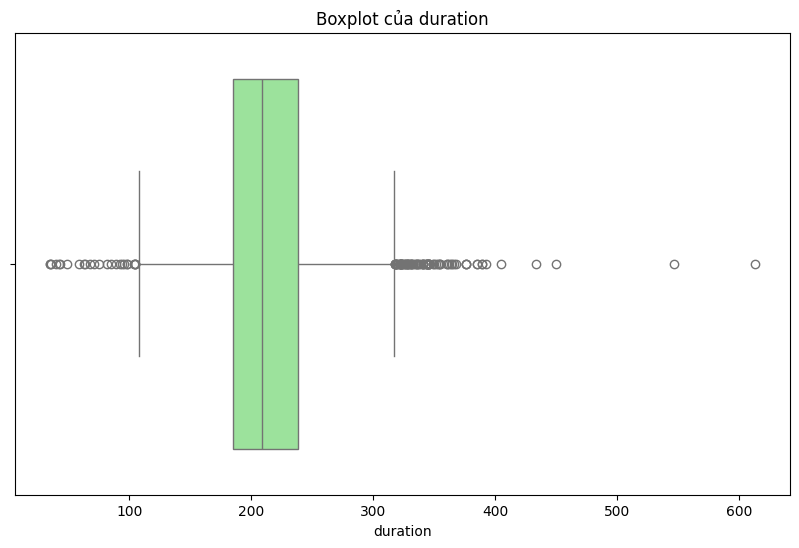

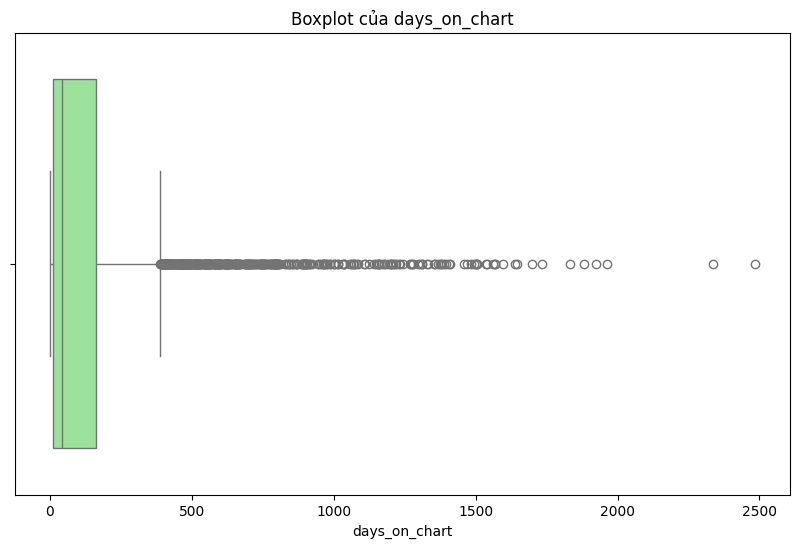

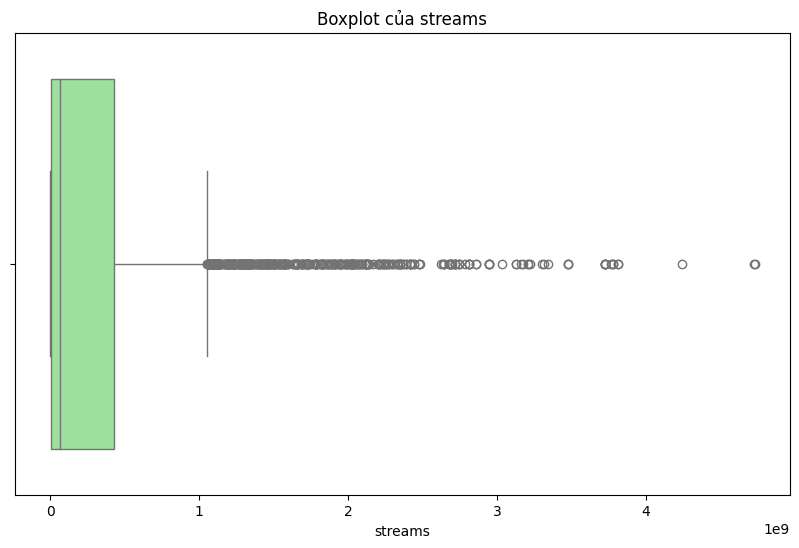

In [215]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=raw_df[col], color='lightgreen')
    plt.title(f'Boxplot của {col}')
    plt.show()

    # Tính toán IQR cho từng cột
    Q1 = raw_df[col].quantile(0.25)
    Q3 = raw_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = raw_df[(raw_df[col] < lower_bound) | (raw_df[col] > upper_bound)]
    if outliers.empty:
        print(f"Không có giá trị ngoại lai nào tìm được cho {col}")

Chúng ta có thể thấy dữ liệu dạng số có nhiều giá trị ngoại lai nhất là với `streams` và `days_on_chart`. Với các giá trị ngoại lai như trên ta có thể thấy được các giá trị ngoại lai này có thể ảnh hưởng đến phân bố. Tuy nhiên là chúng ta sẽ không xử lí các giá trị ngoại lai (loại bỏ nó hay scale lại) này ở đây mà sẽ phân tích kĩ hơn ở phần sau.

<a id="eda23"></a>
### **Phân bố của dữ liệu dạng phân loại**

Chúng ta đã kiểm tra dữ liệu thiếu ở phần trước nên phần này không phải bận tâm về nó nữa (missing_ratio = 0%). Đầu tiên chúng ta sẽ tính các giá trị như sau:
- Số lượng giá trị khác nhau trong mỗi trường, không tính giá trị thiếu: `num_values`
- Tỉ lệ các giá trị khác nhau trong mỗi trường, không tính giá trị thiếu: `value_ratios`

In [216]:
# Tìm các trường thuộc kiểu phân loại
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

cat_col_info = {}

# Tính toán
for col in categorical_cols:    
    num_values = raw_df[col].nunique(dropna = True)
    
    # Tính số các giá trị và tỉ lệ giá trị
    value_ratio = (np.round(raw_df[col].value_counts(normalize=True, ascending=False) * 100, 1)).to_dict()
    
    cat_col_info[col] = {
        "num_values": num_values,
        "value_ratio": value_ratio
    }
    
cat_col_info_df = pd.DataFrame(cat_col_info)
cat_col_info_df.T

num_values                                        value_ratio
id                  3487  {'006LuHbY5Tt9dhbdSOnVq6': 0.0, '569B75eNRVDAB...
track_name          2911  {'Mượn Rượu Tỏ Tình': 0.1, 'Sunflower - Spider...
artist_names        1558  {'BTS': 3.8, 'Taylor Swift': 2.6, 'BLACKPINK':...
source               572  {'BIGHIT MUSIC': 7.3, 'Yin Yang Media': 6.2, '...
peak_rank            199  {1: 7.0, 2: 3.8, 5: 3.0, 3: 2.5, 4: 2.0, 7: 2....
previous_rank        201  {-1: 15.6, 180: 1.0, 177: 0.9, 168: 0.9, 182: ...
rank                 200  {191: 1.6, 199: 1.5, 200: 1.5, 196: 1.5, 195: ...

Có vẻ như có một số bất thường trong dữ liệu. Từ dataframe trên, chúng ta có thể có được một số thông tin về bộ dữ liệu như sau:
- Bất thường là có 3487 id khác nhau nhưng chỉ có 2911 tên bài hát.
- Có 1558 nghệ sĩ trong bộ dữ liệu với tần suất xuất hiện cao nhất là "BTS" với 3.8%.
- Có nhiều hãng đĩa (572 hãng), nhưng hãng đĩa sản xuất cho nhiều bài hát nhất thuộc về "BIGHIT MUSIC" với 7.3% cho `value_ratios`.
- Có quá nhiều thứ hạng trùng nhau trong `rank`. Lưu ý là chúng ta đã sử dụng tổng số lượt nghe `streams` thay vì lượt nghe hàng ngày ban đầu. Nên trường `rank` này không còn ý nghĩa nữa. Vậy nên chúng ta sẽ định nghĩa lại trường `rank` theo thứ hạng cuối cùng của mỗi bài hát, trức là theo `streams` hiện tại.

**Kiểm tra bất thường:**

Ta có thể đoán rằng có lẽ là do có các bài hát trùng tên với nhau dẫn đến việc có số các tên bài khác nhau khác với số các url. Để kiểm tra giả thuyết này, chúng ta sẽ kiểm tra xem có bài hát nào trùng tên với nhau không.

In [218]:
duplicate_names = raw_df[raw_df.duplicated('track_name', keep=False)]
print("Tổng số các bài hát trùng tên:", len(duplicate_names))

duplicate_num = raw_df.groupby('track_name').size().reset_index(name='count')
duplicate_num = duplicate_num[duplicate_num['count'] > 1]

print("Bài hát trùng tên và số lần trùng:")
print(duplicate_num)

Tổng số các bài hát trùng tên: 1061
Bài hát trùng tên và số lần trùng:
                           track_name  count
8                00:00 (Zero O’Clock)      2
18                             1 Phút      3
22                        10 Ngàn Năm      2
36                               2002      2
40                                24h      2
...                               ...    ...
2862            Để Mị Nói Cho Mà Nghe      2
2868                         Độ Tộc 2      2
2888                   đưa em về nhàa      2
2890  để tôi ôm em bằng giai điệu này      2
2903                               是你      2

[485 rows x 2 columns]


Kiểm tra lại số liệu xem có khớp không

In [220]:
print(len(duplicate_names) + 2911 - len(duplicate_num)) # 2911 là số bài hát khác nhau

3487


Vậy lí do là do có nhiều bài hát trùng tên (`num_values` của `track_name` bằng 3487). Nên không có gì bất thường ở đây. Tiếp theo chúng ta sẽ đi đến bất thường ở cột `streams`

**Xử lí bất thường:**

Chúng ta sẽ dùng trường `streams` để xác định thứ hạng cuối cùng của mỗi bài hát. Thông qua việc giá trị của `rank` sẽ theo thứ tự tăng dần theo giá trị của `streams`. Vậy nên chúng ta sẽ sắp xếp lại dữ liệu theo thứ tự giảm dần của `streams` và lấy giá trị cuối cùng của `rank` của mỗi bài hát. Vậy là chúng ta đã xử lí xong bất thường ở trường `rank`.

In [231]:
raw_df = raw_df.sort_values(by='streams', ascending=False).reset_index(drop=True)
raw_df['rank'] = raw_df['streams'].rank(method='first', ascending=False).astype('int64').astype('object')
raw_df.head()

id                                         track_name  \
0  3Z0oQ8r78OUaHvGPiDBR3W                                   Into the Unknown   
1  3AzjcOeAmA57TIOr9zF1ZW                                           Physical   
2  5CLGzJsGqhCEECcpnFQA8x  These Days (feat. Jess Glynne, Macklemore & Da...   
3  42zePe03Iq8tvFcJAIKkp8                D.R.E.A.M. (feat. Ghostface Killah)   
4  34ODRRWSsRbiB6sGI9R9Te                                             Badadu   

                                      artist_names                source  \
0                             Idina Menzel, AURORA   Walt Disney Records   
1                                         Dua Lipa        Warner Records   
2  Rudimental, Jess Glynne, Macklemore, Dan Caplen   Atlantic Records UK   
3                    Miley Cyrus, Ghostface Killah            RCA/Legacy   
4                                          MONSTAR  ST.319 Entertainment   

  release_date  duration peak_rank previous_rank  days_on_chart rank  \
0   2019-11-29       202        50           145             23    1   
1   2020-03-20       200        15           149            105    2   
2   2017-03-03       234        14            -1             86    3   
3   2019-05-17       182        59            59              2    4   
4   2018-11-08       182        45           179             40    5   

      streams  
0  4727746591  
1  4726263786  
2  4238338469  
3  3812743107  
4  3811491910

Vậy là chúng đã xử lí các bất thường và cũng như là khám phá và tiền xử lí dữ liệu xong. Bộ dữ liệu mới sẽ được lưu vào file csv để sử dụng ở phần tiếp theo.

In [232]:
raw_df.to_csv('../new_data/cleaned_data.csv', index=False, encoding='utf-8')
raw_df.sample(5)

id                          track_name  \
1799  5kRTXjVcdAHNCCbiUtJZTR             Tình Đắng Như Ly Cà Phê   
114   6WbADFqMvR8N5u0BvtsWQE  Without You (feat. Sandro Cavazza)   
381   1Axzkl935WrIsBwDqk90yQ    Đưa Nhau Đi Trốn - Chill Version   
2030  1nwdfbj4UyRMpa9L98a4Yi                           Blue Side   
3411  42rme4MN6ki6mXgl4yaZtV                     Tầng Thượng 102   

                artist_names              source release_date  duration  \
1799                Ngơ, NÂN          12 trái lê   2019-09-12       163   
114   Avicii, Sandro Cavazza  Universal Music AB   2018-04-27       231   
381            Đen, Linh Cáo                 Đen   2019-10-04       168   
2030                  j-hope        BIGHIT MUSIC   2021-03-02       199   
3411            Cá Hồi Hoang         Luke Record   2020-09-15       141   

     peak_rank previous_rank  days_on_chart  rank     streams  
1799        74           103            183  1800    52985474  
114          1           109             36   115  2064219143  
381         69           125            507   382  1125552324  
2030         7           190              9  2031    26746964  
3411       183            -1              9  3412      454534

<div id='analysis'></div>

# **V. Phân tích dữ liệu và trực quan hóa**

In [ ]:
df = pd.read_csv('../new_data/cleaned_data.csv', encoding='utf-8')
df.head(5)

id                                         track_name  \
0  3Z0oQ8r78OUaHvGPiDBR3W                                   Into the Unknown   
1  3AzjcOeAmA57TIOr9zF1ZW                                           Physical   
2  5CLGzJsGqhCEECcpnFQA8x  These Days (feat. Jess Glynne, Macklemore & Da...   
3  42zePe03Iq8tvFcJAIKkp8                D.R.E.A.M. (feat. Ghostface Killah)   
4  34ODRRWSsRbiB6sGI9R9Te                                             Badadu   

                                      artist_names                source  \
0                             Idina Menzel, AURORA   Walt Disney Records   
1                                         Dua Lipa        Warner Records   
2  Rudimental, Jess Glynne, Macklemore, Dan Caplen   Atlantic Records UK   
3                    Miley Cyrus, Ghostface Killah            RCA/Legacy   
4                                          MONSTAR  ST.319 Entertainment   

  release_date  duration  peak_rank  previous_rank  days_on_chart  rank  \
0   2019-11-29       202         50            145             23     1   
1   2020-03-20       200         15            149            105     2   
2   2017-03-03       234         14             -1             86     3   
3   2019-05-17       182         59             59              2     4   
4   2018-11-08       182         45            179             40     5   

      streams  
0  4727746591  
1  4726263786  
2  4238338469  
3  3812743107  
4  3811491910

Mục tiêu phân tích của nhóm như đã nêu từ đầu là xu hướng thị hiếu âm nhạc của người nghe ở thị trường Việt Nam. Để có thể có cái nhìn đúng về thị trường âm nhạc trực tuyến ở Việt Nam hiện nay, chúng ta phải biết được mối quan hệ giữa các yếu tố âm nhạc dẫn đến sự thịnh hành của các bài hát. Vì vậy, đầu tiên chúng ta sẽ xem xét liệu đâu là các thể loại nhạc phổ biến nhất ở Việt Nam bằng cách xem xét số lượng bài hát của từng thể loại nhạc, để trả lời cho câu hỏi:
## **1. Mức độ ảnh hưởng của thể loại âm nhạc đến sự thịnh hành của bài hát**
### **1.1. Các thể loại nhạc nào thịnh hành nhất ở Việt Nam?**

Để có thể làm điều này, chúng ta sẽ xem xét các bài hát nằm trong `top_50_df`, trích id - `url` của các bài hát này và so sánh với `df` để xem xem bài hát nào nằm trong bảng xếp hạng. Sau đó, chúng ta sẽ xem xét số lượng bài hát của từng thể loại nhạc.

Số lượng bài hát của từng thể loại nhạc nằm trong top 50 thịnh hành:
        genre  count
0    Nhạc Trẻ     24
1    Rap Việt     13
2  Remix Việt      8
3    Nhạc Hàn      3
4         Pop      1


[Plot chart cho thể loại thịnh hành]

Như đã thấy, các thể loại đang thịnh hành hiện nay là Nhạc Trẻ, Rap, Remix, Nhạc Hàn và Pop. Vậy liệu các thể loại này thịnh hành hơn do có nhiều bài hát trên các nền tảng trực tuyến hơn làm ảnh hưởng đến quyết định chọn nhạc của người nghe, hay là do thị hiếu chung của người nghe nhạc trực tuyến tại Việt Nam.
### **1.2. Sự hiện diện của các thể loại âm nhạc trên thị trường âm nhạc Việt Nam**
Để trả lời cho câu hỏi này, chúng ta sẽ xem xét số lượng bài hát của từng thể loại nhạc trong `df`.

[Tự thêm markdown và biểu đồ]

In [34]:
df['genre'].value_counts()

genre
Rap Việt             1009
Remix Việt           1004
Nhạc Hàn             1001
Blues/Jazz           1000
Latin                1000
Country              1000
Trữ Tình             1000
R&B/Hip Hop/Rap       999
Nhạc Thái             999
Thiếu Nhi             999
Tiền Chiến            999
Cách Mạng             998
Nhạc Hoa              998
Nhạc Nhật             998
Rock Việt             997
Nhạc Trịnh            996
Indie                 931
Rock                  775
Beat                  714
Electronica/Dance     630
Không Lời             509
Nhạc Trẻ              438
Pop                   155
Thể Loại Khác         120
Name: count, dtype: int64

Nhạc Trẻ là thể loại nằm trong bảng xếp hạng thịnh hành hiện nay nhiều nhất nhưng số lượng bài hát có trên trang web trực tuyến này ít hơn nhiều lần so với các thể loại như Rap Việt và Remix Việt. Vậy có nghĩa là người nghe không phải hoàn toàn chọn nhạc do ảnh hưởng từ số lượng bài hát của một bên nào áp đảo mà là do thị hiếu cá nhân của họ. Hoặc cũng có thể là do đây không phải là kênh nhạc trực tuyến người nghe chọn để nghe Rap Việt và Remix Việt nhiều.

Tuy nhiên để có thể biết được rõ ràng hơn về thể loại nhạc ảnh hưởng thế nào đến thị hiếu của người nghe, chúng ta cần phải xem xét thêm ở một bang xếp hạng có thời gian dài hơn và có nhiều bài hát hơn và NhacCuaTui không cung cấp lượt nghe. Nên nhóm sẽ thu thập thêm dữ liệu từ trang Kworb (nơi cung cấp bảng xếp hạng âm nhạc trên nền tảng Spotify, Itunes, Youtube...) để có cái nhìn rõ hơn về điều này.

[Scrape từ trang https://kworb.net/spotify/country/vn_daily_totals.html Đã có làm rồi ở project trước, đồng thời khi scrape đc về rồi lưu ý là id trên trang này tương đương id trên spotify nên là xử lí chuỗi để có thể dùng nó request đc cái thể loại nhạc luôn, xử lí lại thể loại cho nó fit lại với cái trên, vd V-Pop -> Nhạc Trẻ, K-Pop -> Nhạc Hàn]

[Nhớ lưu cái cào về vào csv để trong file data]

Nhưng từ đó chúng ta cũng thấy rằng có vẻ như thính giả Việt Nam vẫn thiên về nghe nhạc Việt. Nhưng bên cạnh đó vẫn có các bài hát quốc tế lọt vào bảng xếp hạng thịnh hành. Điều đó cho thấy có sự xuất hiện của âm nhạc quốc tế trong thị trường âm nhạc Việt Nam. Thậm chí kể cả trong các bài hát được cập nhật trên trang NhacCuaTui, số lượng Nhạc Hàn đứng top 3 thể loại được cập nhật bài hát nhiều nhất. Chứng tỏ rất nhiều người quan tâm đến thể loại này. Vậy trên thị trường âm nhạc Việt Nam, nhạc Việt hay nhạc ngoại quốc đang chiếm ưu thế?
## **2. Nhạc Việt hay Nhạc Ngoại: Xu hướng nghe nhạc nghiêng về bên nào?**

Sau khi đã có cái nhìn nhất định về thị trường âm nhạc Việt Nam, chúng ta sẽ đi sâu hơn về phần cảm nhận của người nghe để biết thêm những yếu tố nào ảnh hưởng đến sự chọn lựa của họ. Câu hỏi đặt ra là những nguyên nhân nào cấu thành sự thành công của một bài hát mà thành công ở đây là được nhiều người đón nhận trên thước đo bảng xếp hạng? Để trả lời cho câu hỏi này, chúng ta sẽ xem xét các câu hỏi sau:

## **3. Thời lượng như thế nào là tối ưu hiện tại?**

[Phân bố của thời lượng bài hát bên df]
[Các bài hát thịnh hành có thời lượng ra sao]


## **4. Nghệ sĩ sĩ nào đang thống trị thị trường âm nhạc Việt Nam?**

**Nhạc từ trong gameshow??? Nhạc phim???** (ngắn hạn trong thời gian hiện tại)

**Leo dài hạn thì khó???** 

## **5. Colab hay solo: Đâu là xu hướng hiện nay?**

### **5.1. So sánh giữa số lượng bài hát solo và bài hát hợp tác trên bảng xếp hạng**

### **5.2. Có phải nghệ sĩ càng nổi tiếng thì càng nhiều người muốn hợp tác không?**

### **5.2. Liệu việc hợp tác để sản xuất nhạc có phải là hiếm trên thị trường Việt Nam hay không**
==> Chắc là ko mới lạ gì đâu, nhưng plot cho có

In [35]:
df

url  \
0      https://www.nhaccuatui.com/bai-hat/re-ndm-wtra...   
1      https://www.nhaccuatui.com/bai-hat/yeu-di-chau...   
2      https://www.nhaccuatui.com/bai-hat/diem-xui-da...   
3      https://www.nhaccuatui.com/bai-hat/mashup-we-d...   
4      https://www.nhaccuatui.com/bai-hat/giu-em-that...   
...                                                  ...   
20265  https://www.nhaccuatui.com/bai-hat/kim-phut-ki...   
20266  https://www.nhaccuatui.com/bai-hat/hu-khong-kh...   
20267  https://www.nhaccuatui.com/bai-hat/sao-hang-a-...   
20268  https://www.nhaccuatui.com/bai-hat/ngao-ngo-an...   
20269  https://www.nhaccuatui.com/bai-hat/regret-anh-...   

                                                    name             artist  \
0                                                 Rê NDM              Wtran   
1                                                 Yêu Đi    Châu Khải Phong   
2                                               Điềm Xui              Daduc   
3      Mashup We Don't Talk Anymore, Để Em Rời Xa (Bi...           Đức Phúc   
4                                        Giữ Em Thật Lâu               Naod   
...                                                  ...                ...   
20265                                  KIM PHÚT, KIM GIỜ              Isaac   
20266                                           Hư không                Kha   
20267                                         SAO HẠNG A  ANH TRAI "SAY HI"   
20268                                           NGÁO NGƠ  ANH TRAI "SAY HI"   
20269                                             REGRET  ANH TRAI "SAY HI"   

                                                composer  \
0      Wtran, Cà Nâu                                 ...   
1                                                Unknown   
2      Daduc                                         ...   
3                                                Unknown   
4      Naod                                          ...   
...                                                  ...   
20265                                            Unknown   
20266  Kha                                           ...   
20267                                            Unknown   
20268                                            Unknown   
20269                                            Unknown   

                                                  lyrics  duration     genre  \
0      Rê NDM – WTran ft. Cà Nâu  WTran: Chú bé loắt ...       195  Nhạc Trẻ   
1                                                Unknown       272  Nhạc Trẻ   
2      Daduc - Điềm Xui (We Broke Up Yesterday)  thôi...       205  Nhạc Trẻ   
3                                                Unknown       298  Nhạc Trẻ   
4      Bài hát: Giữ Em Thật Lâu - Naod  Còn điều gì e...       254  Nhạc Trẻ   
...                                                  ...       ...       ...   
20265  Vậy đây là phút giây cuối thật sao Sau bao nhi...       295  Nhạc Trẻ   
20266  Xin lỗi  Xin lỗi.. vì đã không hiểu về mình Xi...       354       NaN   
20267  Rảnh không baby Anh phi qua này Em thèm đồ tây...       252  Nhạc Trẻ   
20268  [Intro] Hey, Kewtiie  [Verse 1: HIEUTHUHAI, An...       252  Nhạc Trẻ   
20269  Chẳng cần thiết những đến những ký ức đôi ta C...       252  Nhạc Trẻ   

         origin            id  
0      VIỆT NAM  9gvVeiELZlKq  
1      VIỆT NAM  W3puBHmNLaTH  
2      VIỆT NAM  9IQuJunOhc8Y  
3      VIỆT NAM  WEMx8xJZYY4g  
4      VIỆT NAM  TPDciU83yMeU  
...         ...           ...  
20265  VIỆT NAM  I27zoLp2Ovzz  
20266       NaN  zg8rqHWqlAkT  
20267  VIỆT NAM  9hVrZ2qY9XqD  
20268  VIỆT NAM  gwkZrcqfbbOI  
20269  VIỆT NAM  0U4Pr5esABDT  

[20270 rows x 9 columns]

Chúng ta đã điểm qua nhiều yếu tố để một bài hát thành công, cũng như những yếu tố ảnh hưởng đến sự chọn lựa của người nghe. Tiếp sau đây, chúng ta sẽ đến với vấn đề cuối cùng phải xem xét. Đó chính là:

## **6. Xô đổ kỉ lục có khó không: Có phải càng về sau, thời gian để bức phá tiến vào bảng xếp hạng càng rút ngắn?**

Chúng ta đều biết có những bài hát dù đã xuất hiện từ lâu trên bảng xếp hạng nhưng vẫn không thể bị xô đổ, cũng có những bài hát rất nhanh bức phá để lọt vào bảng xếp hạng. Tuy thế, tiến vào bảng xếp hạng đã khó, vào bảng xếp hạng rồi thì còn khó hơn để giữ vững vị trí của mình và thậm trí là bức phá các vị trí trên. Để có cái nhìn rõ ràng hơn về vấn đề này, chúng ta sẽ cùng đi tìm câu trả lời cho câu hỏi trên.